# External


In [ ]:
! pip install -U pandasql
import torch
import pandas as pd
import pandasql as ps
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive 

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/tarak/Players-Block-20211116T025030Z-001/Players-Block/GNN/data/

[Errno 2] No such file or directory: 'drive/MyDrive/tarak/Players-Block-20211116T025030Z-001/Players-Block/GNN/data/'
/content/drive/.shortcut-targets-by-id/1MeacoHD16_nfxfWKec4Nch65B3Nxp4K-/tarak/Players-Block-20211116T025030Z-001/Players-Block/GNN/data


In [ ]:
!ls

 Competes_in_edges.csv
 Comp_season_nodes.csv
 dataset_lineup_6feat_no_agg_box_score.csv
 dataset_lineup_agg_box_score_features.csv
 Field_player_nodes.csv
 field_players_plus_features.csv
 GK_nodes.csv
 gnn_data.docx
 gnn_data.pdf
 goal_keepers_plus_features.csv
 Hosts_edges.csv
 Manager_nodes.csv
 Manages_edges.csv
 matches.csv
 matches_lineup_6feat_no_agg_box_score.csv
 matches_lineup_agg_box_score_features.csv
 player_6feat_no_agg_box_score.csv
 Plays_for_edges.csv
 Plays_with_edges.csv
 sa_model1.pth
 sa_model2.pth
 sa_model3.pth
 sa_model4.pth
 sa_model5.pth
 SetAggModel.pth
'Team_nodes(1).csv'
 Team_nodes.csv
 team_nodes_plus_features.csv
 team_players_game_6feat_no_agg_box_score.csv
 team_players_game_agg_box_score_features.csv


# Data Prep

## Data for BC


In [ ]:
PlaysWithEdgesDf = pd.read_csv('./Plays_with_edges.csv')
CompetesInEdgesDf = pd.read_csv('./Competes_in_edges.csv')
CompSeasonNodesDf = pd.read_csv ('Comp_season_nodes.csv')
FieldPlayerNodesDf = pd.read_csv('Field_player_nodes.csv')
GKNodesDf = pd.read_csv('GK_nodes.csv')
HostsEdgesDf = pd.read_csv('Hosts_edges.csv')
ManagerNodesDf = pd.read_csv('Manager_nodes.csv')
ManagesEdgesDf = pd.read_csv('Manages_edges.csv')
PlaysForEdgesDf = pd.read_csv('Plays_for_edges.csv')
TeamNodesDf = pd.read_csv('Team_nodes.csv')

# %cd ../../../../../../../../
# !ls
FeatureTeamNodesDf = pd.read_csv('team_nodes_plus_features.csv')

In [ ]:
FeatureTeamNodesDf = FeatureTeamNodesDf.fillna(0).reset_index()

In [ ]:
HostsEdgesDf.columns

Index(['gameId', 'homeTeamId', 'awayTeamId', 'gameDate', 'seasonId',
       'competitionId', 'competitionName', 'homeTeamName', 'awayTeamName',
       'preGame_venueId', 'preGame_city', 'preGame_country', 'preGame_lat',
       'preGame_long', 'preGame_field_length_m', 'preGame_field_width_m',
       'preGame_capacity', 'preGame_surface', 'preGame_is_behind_closed_doors',
       'preGame_homeTeamDominance', 'preGame_awayTeamDominance',
       'preGame_venueName', 'postGame_tgt_half_gd', 'postGame_tgt_gd',
       'postGame_tgt_homeTeamGoals', 'postGame_tgt_awayTeamGoals',
       'postGame_tgt_half_homeTeamGoals', 'postGame_tgt_half_awayTeamGoals',
       'postGame_tgt_outcome', 'postGame_tgt_half_outcome', 'preGame_odds1',
       'preGame_odds2', 'preGame_oddsX', 'src_nodeId', 'src_nodeName',
       'edge_type', 'dest_nodeId', 'dest_nodeName'],
      dtype='object')

In [ ]:
query = """ 
  select preGame_steph, preGame_quality_overall,
          preGame_quality_attack, preGame_quality_midfield,
          preGame_quality_defence, preGame_proportion_pts,
          agg_postGame_goals_scored,
          agg_postGame_goals_conceded,
          agg_postGame_index,
          agg_postGame_total_shots,
          agg_postGame_total_xg,
          agg_postGame_total_big_chances,
          agg_postGame_total_key_passes,
          preGame_odds1,
          preGame_odds2,
          preGame_oddsX,
          preGame_homeTeamDominance,
          preGame_awayTeamDominance
  from FeatureTeamNodesDf T inner join HostsEdgesDf H
    on T.nodeName = H.dest_nodeName
  order by T.gameDate, T.gameId
"""
away_features = ps.sqldf(query)
query = """ 
  select preGame_steph, preGame_quality_overall,
          preGame_quality_attack, preGame_quality_midfield,
          preGame_quality_defence, preGame_proportion_pts,
          agg_postGame_goals_scored,
          agg_postGame_goals_conceded,
          agg_postGame_index,
          agg_postGame_total_shots,
          agg_postGame_total_xg,
          agg_postGame_total_big_chances,
          agg_postGame_total_key_passes,
          preGame_odds1,
          preGame_odds2,
          preGame_oddsX,
          preGame_homeTeamDominance,
          preGame_awayTeamDominance
  from FeatureTeamNodesDf T inner join HostsEdgesDf H
    on T.nodeName = H.src_nodeName
  order by T.gameDate, T.gameId
"""
home_features = ps.sqldf(query)
ps.sqldf(query)

query = """
  select postGame_tgt_gd
  from HostsEdgesDf H inner join FeatureTeamNodesDf T
    on H.src_nodeName = T.nodeName
  order by T.gameDate, T.gameId
"""
bc_results = ps.sqldf(query)

In [ ]:
bc_odds = home_features[['preGame_odds1', 'preGame_odds2', 'preGame_oddsX']].copy()
bo_array = bc_odds.to_numpy()
bc_odds.loc[:,:] = (1 / bo_array) / np.sum(1 / bo_array, axis=1, keepdims=True)

In [ ]:
bc_results = torch.from_numpy(bc_results.values).view(-1)
dummy = 6
bc_results[bc_results > 0] = dummy + 2
bc_results[bc_results == 0] = dummy + 1
bc_results[bc_results < 0] = dummy + 0
bc_results -= dummy
bc_y = bc_results[:]

bc_home_features = torch.from_numpy(home_features.values)
bc_away_features = torch.from_numpy(away_features.values)

In [ ]:
FeatureTeamNodesDf.columns

Index(['index', 'Unnamed: 0', 'teamName', 'postGame_side', 'competitionId',
       'gameId', 'teamId', 'preGame_steph', 'preGame_quality_overall',
       'preGame_quality_attack', 'preGame_quality_midfield',
       'preGame_quality_defence', 'preGame_proportion_pts', 'gameDate',
       'teamName.1', 'competitionName', 'nodeId', 'nodeName', 'year', 'month',
       'postGame_goals_scored', 'agg_postGame_goals_scored',
       'postGame_goals_conceded', 'agg_postGame_goals_conceded',
       'postGame_index', 'agg_postGame_index', 'postGame_total_shots',
       'agg_postGame_total_shots', 'postGame_total_xg',
       'agg_postGame_total_xg', 'postGame_total_big_chances',
       'agg_postGame_total_big_chances', 'postGame_total_key_passes',
       'agg_postGame_total_key_passes'],
      dtype='object')

## Lineup + Agg. Box Score Features

In [ ]:
PlaysWithEdgesDf = pd.read_csv('./Plays_with_edges.csv')
CompetesInEdgesDf = pd.read_csv('./Competes_in_edges.csv')
CompSeasonNodesDf = pd.read_csv ('Comp_season_nodes.csv')
FieldPlayerNodesDf = pd.read_csv('Field_player_nodes.csv')
GKNodesDf = pd.read_csv('GK_nodes.csv')
HostsEdgesDf = pd.read_csv('Hosts_edges.csv')
ManagerNodesDf = pd.read_csv('Manager_nodes.csv')
ManagesEdgesDf = pd.read_csv('Manages_edges.csv')
PlaysForEdgesDf = pd.read_csv('Plays_for_edges.csv')
TeamNodesDf = pd.read_csv('Team_nodes.csv')

# %cd ../../../../../../../../
# !ls
FeatureTeamNodesDf = pd.read_csv('team_nodes_plus_features.csv')

In [ ]:
fpDf = pd.read_csv('./field_players_plus_features.csv')
gkDf = pd.read_csv('./goal_keepers_plus_features.csv')

In [ ]:
fpDf.columns

Index(['Unnamed: 0', 'name', 'nodeName', 'player_optaId', 'postGame_subbedOut',
       'postGame_RedCard', 'postGame_minPlayed', 'preGame_side',
       'preGame_line', 'preGame_position', 'playerId', 'postGame_positions',
       'preGame_overall', 'preGame_potential', 'preGame_marketValueMilEuro',
       'preGame_preferredFoot', 'preGame_ageDays', 'gameId', 'preGame_xgpm',
       'preGame_xppm', 'teamId', 'teamName', 'gameDate', 'nodeId',
       'postGame_error', 'agg_postGame_error', 'postGame_clearance',
       'agg_postGame_clearance', 'postGame_index', 'agg_postGame_index',
       'postGame_shots', 'agg_postGame_shots', 'postGame_shots_on_target',
       'agg_postGame_shots_on_target', 'postGame_shots_left_foot',
       'agg_postGame_shots_left_foot', 'postGame_shots_right_foot',
       'agg_postGame_shots_right_foot', 'postGame_shots_head',
       'agg_postGame_shots_head', 'postGame_shots_other',
       'agg_postGame_shots_other', 'postGame_goals', 'agg_postGame_goals',
       'p

In [ ]:
gkDf.columns

Index(['Unnamed: 0', 'name', 'nodeName', 'player_optaId', 'postGame_subbedOut',
       'postGame_RedCard', 'postGame_minPlayed', 'preGame_side',
       'preGame_line', 'preGame_position', 'playerId', 'preGame_overall',
       'preGame_potential', 'preGame_marketValueMilEuro',
       'preGame_preferredFoot', 'preGame_ageDays', 'preGame_xgpm',
       'preGame_xppm', 'gameId', 'teamId', 'teamName', 'gameDate', 'nodeId',
       'postGame_error', 'agg_postGame_error', 'postGame_clearance',
       'agg_postGame_clearance', 'postGame_index', 'agg_postGame_index',
       'postGame_pickUp', 'agg_postGame_pickUp', 'postGame_punch',
       'agg_postGame_punch', 'postGame_save', 'agg_postGame_save'],
      dtype='object')

In [ ]:
fp_agg_columns = [
 'agg_postGame_shots',
 'agg_postGame_shots_on_target',
 'agg_postGame_shots_left_foot',
 'agg_postGame_shots_right_foot',
 'agg_postGame_shots_head',
 'agg_postGame_shots_other',
 'agg_postGame_goals',
 'agg_postGame_goals_left_foot',
 'agg_postGame_goals_right_foot',
 'agg_postGame_goals_head',
 'agg_postGame_goals_other',
 'agg_postGame_xG',
 'agg_postGame_cross',
 'agg_postGame_cross_success',
 'agg_postGame_pass',
 'agg_postGame_pass_success',
 'agg_postGame_pass_final_third',
 'agg_postGame_pass_final_third_success',
 'agg_postGame_pass_forward',
 'agg_postGame_pass_forward_success',
 'agg_postGame_dribble',
 'agg_postGame_dribble_success',
 'agg_postGame_tackle',
 'agg_postGame_tackle_success',
 'agg_postGame_interception',
 'agg_postGame_challenge',
 'agg_postGame_ball_recovery',
 'agg_postGame_ball_lost',
 'agg_postGame_key_pass'
]

gk_agg_columns = [
 'agg_postGame_pickUp',
 'agg_postGame_punch',
 'agg_postGame_save'
]

common_columns = [
 'agg_postGame_error',
 'agg_postGame_clearance',
 'agg_postGame_index',
 'name',
 'preGame_overall',
 'preGame_potential',
 'preGame_marketValueMilEuro',
 'preGame_ageDays',
 'preGame_xppm',
 'preGame_xgpm'
]
cc_labels = [
 'agg_postGame_error',
 'agg_postGame_clearance',
 'agg_postGame_index',
 'lineup',
  'vg_rating',
  'potential',
  'market_value',
  'age_days',
  'xppm',
  'xgpm'
]

In [ ]:
query = """
  select T.teamName,
"""
for col, label in zip(common_columns, cc_labels):
  query += f"""
         G.{col} || ' - ' || group_concat(FP.{col}, ' - ') as {label},
"""
for agg_col in fp_agg_columns:
  query += f"""
            '0.0' || ' - ' || group_concat(FP.{agg_col}, ' - ') as {agg_col},
          """
fp_zeros = ('0.0 - ' * 10)[: -3]
for agg_col in gk_agg_columns:
  query += f"""
            {agg_col} || ' - ' || '{fp_zeros}' as {agg_col},
          """
query += """
         T.gameId,
         T.postGame_goals_scored as goal,
         T.competitionName as league,
         T.gameDate as date

  from fpDf as FP inner join (
    select *
    from TeamNodesDf
    order by gameDate, gameId, postGame_side desc
  ) as T
   on T.gameId = FP.gameId and FP.teamName = T.teamName
   inner join gkDf G
   on G.teamName = T.teamName and T.gameId = G.gameId
  group by T.gameDate, T.gameId, T.postGame_side
"""
agg_feat_team_players_gameDf = ps.sqldf(query)
# agg_feat_team_players_gameDf.to_csv('team_players_game_agg_box_score_features.csv')
agg_feat_team_players_gameDf

,teamName,agg_postGame_error,agg_postGame_clearance,agg_postGame_index,lineup,vg_rating,potential,market_value,age_days,xppm,...,agg_postGame_ball_recovery,agg_postGame_ball_lost,agg_postGame_key_pass,agg_postGame_pickUp,agg_postGame_punch,agg_postGame_save,gameId,goal,league,date
0,Bristol City,None,None,None,Niki Maenpaa - Eros Pisano - Marley Watkins - ...,68.0 - 72.0 - 69.0 - 70.0 - 70.0 - 70.0 - 68.0...,68.0 - 72.0 - 69.0 - 71.0 - 71.0 - 70.0 - 68.0...,0.0525 - 2.2 - 1.1 - 1.7 - 2.1 - 1.9 - 0.095 -...,12263.0 - 11467.0 - 10171.0 - 10120.0 - 10011....,-0.127213322 - -0.19548093 - -0.072781666 - 0....,...,None,None,None,None,None,None,3a604f5616b39eb17fc8d1eed07d5248e387bf400294b2...,3,England Championship,2018-08-21T18:45:00.000Z
1,Queens Park Rangers,None,None,None,Matt Ingram - Alex Baptiste - Angel Rangel - L...,64.0 - 70.0 - 73.0 - 74.0 - 68.0 - 75.0 - 70.0...,72.0 - 70.0 - 73.0 - 77.0 - 73.0 - 76.0 - 71.0...,0.05 - 1.2 - 1.1 - 7.0 - 1.0 - 6.5 - 2.1 - 2.8...,9012.0 - 11890.0 - 13081.0 - 9648.0 - 9284.0 -...,-0.361290054 - 0.029316164 - -0.202769976 - -0...,...,None,None,None,None,None,None,3a604f5616b39eb17fc8d1eed07d5248e387bf400294b2...,0,England Championship,2018-08-21T18:45:00.000Z
2,Hull City,None,None,None,David Marshall - Fraizer Campbell - Eric Licha...,71.0 - 69.0 - 69.0 - 71.0 - 71.0 - 71.0 - 68.0...,71.0 - 69.0 - 69.0 - 71.0 - 74.0 - 75.0 - 73.0...,1.4 - 1.1 - 0.0825 - 2.2 - 3.0 - 3.1 - 1.0 - 0...,12222.0 - 11301.0 - 10869.0 - 11687.0 - 9524.0...,-0.052860584 - 0.246462376 - -0.383620298 - -0...,...,None,None,None,None,None,None,58b1242154c8055252582229abfc4680460278834c4433...,3,England Championship,2018-08-21T18:45:00.000Z
3,Rotherham United,None,None,None,Marek Rodak - Richard Wood - Joe Mattock - Jon...,65.0 - 65.0 - 66.0 - 66.0 - 65.0 - 66.0 - 66.0...,73.0 - 65.0 - 66.0 - 68.0 - 67.0 - 70.0 - 70.0...,0.06 - 0.0375 - 0.0525 - 0.08 - 0.0675 - 0.085...,7921.0 - 12101.0 - 10326.0 - 9529.0 - 9805.0 -...,-0.056845074 - -0.069836172 - -0.056847772 - -...,...,None,None,None,None,None,None,58b1242154c8055252582229abfc4680460278834c4433...,2,England Championship,2018-08-21T18:45:00.000Z
4,Ipswich Town,None,None,None,Bartosz Bialkowski - Luke Chambers - Cole Skus...,75.0 - 71.0 - 71.0 - 67.0 - 70.0 - 65.0 - 67.0...,75.0 - 71.0 - 71.0 - 71.0 - 75.0 - 69.0 - 70.0...,4.5 - 1.6 - 1.6 - 0.0825 - 2.0 - 0.0725 - 0.09...,11370.0 - 12016.0 - 11833.0 - 9645.0 - 9471.0 ...,-0.26088178 - -0.03583609 - 0.083123404 - -0.0...,...,None,None,None,None,None,None,c0c48eee0b1a42e0d84cb0a947fe2c64f9e1aa7015922f...,0,England Championship,2018-08-21T18:45:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8003,Levante,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.25...,0.666666666666667 - 1.5 - 2.25 - 0.0 - 0.75 - ...,1.01372806966667 - 0.78656579075 - -0.54853961...,Dani Cárdenas - Tono - Oscar Duarte - Roger - ...,69.0 - 74.0 - 73.0 - 79.0 - 74.0 - 76.0 - 79.0...,77.0 - 74.0 - 73.0 - 79.0 - 79.0 - 77.0 - 82.0...,2.0 - 3.0 - 2.0 - 17.0 - 6.0 - 9.0 - 24.0 - 4....,8820.0 - 11518.0 - 11675.0 - 11096.0 - 9353.0 ...,-0.077330038 - -0.16632638 - -0.160066184 - -0...,...,0.0 - 5.0 - 7.5 - 1.5 - 8.25 - 5.25 - 5.75 - 7...,0.0 - 3.0 - 2.5 - 3.75 - 4.75 - 3.25 - 6.5 - 3...,0.0 - 0.25 - 0.25 - 0.75 - 0.0 - 0.5 - 0.5 - 0...,3.66666666666667 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0...,0.666666666666667 - 0.0 - 0.0 - 0.0 - 0.0 - 0....,2.66666666666667 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0...,0dd5f2b145867283932a47fb03be7b9bc56d89f8250ece...,2,Spain Primera Division,2021-05-21T19:00:00.000Z
8004,Villarreal,0.0 - 0.25 - 0.25 - 0.0 - 0.25 - 0.0 - 0.25 - ...,1.0 - 3.75 - 1.5 - 0.75 - 2.75 - 0.25 - 0.25 -...,1.6495949035 - 1.72289995475 - 0.73075521925 -...,Geronimo Rulli - Raul Albiol - Étienne Capoue ...,80.0 - 82.0 - 78.0 - 85.0 - 79.0 - 83.0 - 79.0...,80.0 - 82.0 - 78.0 - 85.0 - 79.0 - 83.0 - 79.0...,15.0 - 10.0 - 11.0 - 44.0 - 15.0 - 37.0 - 17.0...,10594.0 - 13044.0 - 12003.0 - 11724.0 - 11137....,-0.039779654 - 0.185866854 - 

In [ ]:
agg_feat_team_players_gameDf.columns

Index(['teamName', 'agg_postGame_error', 'agg_postGame_clearance',
       'agg_postGame_index', 'lineup', 'vg_rating', 'potential',
       'market_value', 'age_days', 'xppm', 'xgpm', 'agg_postGame_shots',
       'agg_postGame_shots_on_target', 'agg_postGame_shots_left_foot',
       'agg_postGame_shots_right_foot', 'agg_postGame_shots_head',
       'agg_postGame_shots_other', 'agg_postGame_goals',
       'agg_postGame_goals_left_foot', 'agg_postGame_goals_right_foot',
       'agg_postGame_goals_head', 'agg_postGame_goals_other',
       'agg_postGame_xG', 'agg_postGame_cross', 'agg_postGame_cross_success',
       'agg_postGame_pass', 'agg_postGame_pass_success',
       'agg_postGame_pass_final_third',
       'agg_postGame_pass_final_third_success', 'agg_postGame_pass_forward',
       'agg_postGame_pass_forward_success', 'agg_postGame_dribble',
       'agg_postGame_dribble_success', 'agg_postGame_tackle',
       'agg_postGame_tackle_success', 'agg_postGame_interception',
       'agg_postG

In [ ]:
columns = [
   'goal', 'agg_postGame_error', 'agg_postGame_clearance',
       'agg_postGame_index', 'lineup', 'vg_rating', 'potential',
       'market_value', 'age_days', 'xppm', 'xgpm', 'agg_postGame_shots',
       'agg_postGame_shots_on_target', 'agg_postGame_shots_left_foot',
       'agg_postGame_shots_right_foot', 'agg_postGame_shots_head',
       'agg_postGame_shots_other', 'agg_postGame_goals',
       'agg_postGame_goals_left_foot', 'agg_postGame_goals_right_foot',
       'agg_postGame_goals_head', 'agg_postGame_goals_other',
       'agg_postGame_xG', 'agg_postGame_cross', 'agg_postGame_cross_success',
       'agg_postGame_pass', 'agg_postGame_pass_success',
       'agg_postGame_pass_final_third',
       'agg_postGame_pass_final_third_success', 'agg_postGame_pass_forward',
       'agg_postGame_pass_forward_success', 'agg_postGame_dribble',
       'agg_postGame_dribble_success', 'agg_postGame_tackle',
       'agg_postGame_tackle_success', 'agg_postGame_interception',
       'agg_postGame_challenge', 'agg_postGame_ball_recovery',
       'agg_postGame_ball_lost', 'agg_postGame_key_pass',
       'agg_postGame_pickUp', 'agg_postGame_punch', 'agg_postGame_save'
]
query = """
  select T2.teamName as home_team, 
         T1.teamName as away_team,
         T1.league,
         T1.date,
         case 
            when (T2.goal - T1.goal) > 0 then 'win'
            when (T2.goal - T1.goal) = 0 then 'tie'
            when (T2.goal - T1.goal) < 0 then 'loss'
          end as result,
  """
for column in columns:
  query += f"""
    T2.{column} as home_{column},
    T1.{column} as away_{column},
  """
query += """
    T1.gameId
  from agg_feat_team_players_gameDf T1
    inner join agg_feat_team_players_gameDf T2
     on T1.gameId = T2.gameId and T1.teamName <> T2.teamName
"""
_ = ps.sqldf(query)
agg_feat_matches_players = _[_.index % 2 == 0].reset_index().drop('index', axis=1)
agg_feat_matches_players = agg_feat_matches_players.fillna(value=np.nan)
agg_feat_matches_players = agg_feat_matches_players.fillna(('0.0 - ' * 11)[:-3])
agg_feat_matches_players.to_csv('matches_lineup_agg_box_score_features.csv')
agg_feat_matches_players

,home_team,away_team,league,date,result,home_goal,away_goal,home_agg_postGame_error,away_agg_postGame_error,home_agg_postGame_clearance,...,away_agg_postGame_ball_lost,home_agg_postGame_key_pass,away_agg_postGame_key_pass,home_agg_postGame_pickUp,away_agg_postGame_pickUp,home_agg_postGame_punch,away_agg_postGame_punch,home_agg_postGame_save,away_agg_postGame_save,gameId
0,Queens Park Rangers,Bristol City,England Championship,2018-08-21T18:45:00.000Z,loss,0,3,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,3a604f5616b39eb17fc8d1eed07d5248e387bf400294b2...
1,Rotherham United,Hull City,England Championship,2018-08-21T18:45:00.000Z,loss,2,3,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,58b1242154c8055252582229abfc4680460278834c4433...
2,Derby County,Ipswich Town,England Championship,2018-08-21T18:45:00.000Z,win,2,0,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,c0c48eee0b1a42e0d84cb0a947fe2c64f9e1aa7015922f...
3,Swansea City,Leeds United,England Championship,2018-08-21T18:45:00.000Z,tie,2,2,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,d0cc49c3230e300b529b270951b3b70b3224481add8354...
4,Aston Villa,Brentford,England Championship,2018-08-22T18:45:00.000Z,tie,2,2,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 -

In [ ]:
feature_types = [
 'agg_postGame_error', 'agg_postGame_clearance',
  'agg_postGame_index', 'vg_rating', 'potential',
  'market_value', 'age_days', 'xppm', 'xgpm', 'agg_postGame_shots',
  'agg_postGame_shots_on_target', 'agg_postGame_shots_left_foot',
  'agg_postGame_shots_right_foot', 'agg_postGame_shots_head',
  'agg_postGame_shots_other', 'agg_postGame_goals',
  'agg_postGame_goals_left_foot', 'agg_postGame_goals_right_foot',
  'agg_postGame_goals_head', 'agg_postGame_goals_other',
  'agg_postGame_xG', 'agg_postGame_cross', 'agg_postGame_cross_success',
  'agg_postGame_pass', 'agg_postGame_pass_success',
  'agg_postGame_pass_final_third',
  'agg_postGame_pass_final_third_success', 'agg_postGame_pass_forward',
  'agg_postGame_pass_forward_success', 'agg_postGame_dribble',
  'agg_postGame_dribble_success', 'agg_postGame_tackle',
  'agg_postGame_tackle_success', 'agg_postGame_interception',
  'agg_postGame_challenge', 'agg_postGame_ball_recovery',
  'agg_postGame_ball_lost', 'agg_postGame_key_pass',
  'agg_postGame_pickUp', 'agg_postGame_punch', 'agg_postGame_save']
sep = ' - '
corrupt = []
for f_type in feature_types:
  home_column = f'home_{f_type}'
  away_column = f'away_{f_type}'
  home_feature = agg_feat_matches_players[home_column].values.astype('str')
  away_feature = agg_feat_matches_players[away_column].values.astype('str')
  home_feature = np.char.split(home_feature, sep)
  away_feature = np.char.split(away_feature, sep)

  home_condition = np.array(list(map(len, home_feature)))
  away_condition = np.array(list(map(len, away_feature)))
  # print(np.unique(np.concatenate(
  #     (np.argwhere(home_condition != 11), np.argwhere(away_condition != 11))
  # )).shape)
  # print(np.argwhere(home_condition != 11).shape)
  # print(np.argwhere(away_condition != 11).shape)
  # print(f_type)
  corrupt.append(np.argwhere(home_condition != 11))
  corrupt.append(np.argwhere(away_condition != 11))

from itertools import chain
corrupt_indcs = np.unique(np.array(list(chain.from_iterable(list(map(lambda z: z.reshape(-1).tolist(), corrupt))))))

dataset = agg_feat_matches_players.drop(corrupt_indcs).reset_index()
dataset

,index,home_team,away_team,league,date,result,home_goal,away_goal,home_agg_postGame_error,away_agg_postGame_error,...,away_agg_postGame_ball_lost,home_agg_postGame_key_pass,away_agg_postGame_key_pass,home_agg_postGame_pickUp,away_agg_postGame_pickUp,home_agg_postGame_punch,away_agg_postGame_punch,home_agg_postGame_save,away_agg_postGame_save,gameId
0,0,Queens Park Rangers,Bristol City,England Championship,2018-08-21T18:45:00.000Z,loss,0,3,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,3a604f5616b39eb17fc8d1eed07d5248e387bf400294b2...
1,1,Rotherham United,Hull City,England Championship,2018-08-21T18:45:00.000Z,loss,2,3,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,58b1242154c8055252582229abfc4680460278834c4433...
2,2,Derby County,Ipswich Town,England Championship,2018-08-21T18:45:00.000Z,win,2,0,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,c0c48eee0b1a42e0d84cb0a947fe2c64f9e1aa7015922f...
3,3,Swansea City,Leeds United,England Championship,2018-08-21T18:45:00.000Z,tie,2,2,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,d0cc49c3230e300b529b270951b3b70b3224481add8354...
4,4,Aston Villa,Brentford,England Championship,2018-08-22T18:45:00.000Z,tie,2,2,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 - 0.0 ...,174dba7291174b4dbbfa9ea12dd944bb45bdd8ed905524...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,3999,Valencia CF,Eibar,Spain Primera Division,2021-05-16T16:30:00.000Z,win,4,1,0.5 - 0.0 - 0.25 - 0.0 - 0.0 - 

In [ ]:
dataset.to_csv('./dataset_lineup_agg_box_score_features.csv')

# Models

In [ ]:
def train(model, home, away, results, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  output = model(home, away)
  loss = criterion(output, results)
  loss.backward()
  optimizer.step() 
  return loss.item()


@torch.no_grad()
def eval(model, home, away, results):
  model.eval()
  output = model(home, away).argmax(-1)
  correct = (output == results).sum().item()
  return (correct / results.shape[0])

## Blade Chest Model

In [ ]:
from torch.nn import Module, Linear, NLLLoss, Tanh, BatchNorm1d, Dropout, LogSoftmax, PairwiseDistance
from torch.optim import Adam
from torchsummary import summary

In [ ]:
class BladeChest(Module):
  def __init__(self, feature_size, hidden_size, dropout_rate=0.5):
    super(BladeChest, self).__init__()
    self.feature_size = feature_size
    self.hidden_size = hidden_size
    self.blade_transfrom = Linear(self.feature_size, self.hidden_size)
    self.chest_transform = Linear(self.feature_size, self.hidden_size)
    self.activation = Tanh()
    self.feature_bn = BatchNorm1d(self.feature_size)
    self.hidden_bn = BatchNorm1d(self.hidden_size)
    self.regularizer = Dropout(dropout_rate)
    self.result_transform = Linear(1, 3)
    self.distance_fn = PairwiseDistance()
    self.classifier = LogSoftmax(-1)

  def _matchup_score(self, away_blade, home_chest, home_blade, away_chest):
    return self.distance_fn(away_blade, home_chest).pow(2) - self.distance_fn(home_chest, away_blade).pow(2)

  def encode_team(self, x_team):
    h_team = self.feature_bn(x_team)

    team_blade = self.blade_transfrom(h_team)
    team_blade = self.hidden_bn(team_blade)
    team_blade = self.regularizer(team_blade)

    team_chest = self.chest_transform(h_team)
    team_chest = self.hidden_bn(team_chest)
    team_chest = self.regularizer(team_chest)

    return team_blade, team_chest

  def forward(self, x_home, x_away):
    home_blade, home_chest = self.encode_team(x_home)
    away_blade, away_chest = self.encode_team(x_away)
    h_home = self.feature_bn(x_home)
    h_away = self.feature_bn(x_away)

    matchup = self._matchup_score(away_blade, home_chest, home_blade, away_chest).view(-1, 1)
    result_h = self.result_transform(matchup)
    result_h = self.regularizer(result_h)

    return self.classifier(result_h)

## Set Agg Model

In [ ]:
import torch
from torch.nn import Module, Linear, NLLLoss, Tanh, BatchNorm1d, Dropout, LogSoftmax, PairwiseDistance, Conv1d, ReLU, ModuleList
from torch.optim import Adam

In [ ]:
class SetAgg(Module):
  def __init__(self, feature_size, player_hidden_size, team_hidden_size, class_hidden_size, dropout=0.4):
    super(SetAgg, self).__init__()
    self.dropout_rate = dropout
    self.regularizer = Dropout(self.dropout_rate)
    self.player_mlp_shape = [feature_size] + player_hidden_size
    self.team_mlp_shape = [self.player_mlp_shape[-1]] + team_hidden_size
    self.class_mlp_shape = [self.team_mlp_shape[-1] * 2] + class_hidden_size + [3]
    player_mlp_list = [
                      Conv1d(
                          in_channels=self.player_mlp_shape[i], 
                          out_channels=self.player_mlp_shape[i+1], 
                          kernel_size=1)
                      for i in range(len(self.player_mlp_shape[:-1]))
                      ]
    team_mlp_list = [
                      Linear(self.team_mlp_shape[i], self.team_mlp_shape[i+1])
                      for i in range(len(self.team_mlp_shape[:-1]))
                    ]
    class_mlp_list = [
                      Linear(self.class_mlp_shape[i], self.class_mlp_shape[i+1])
                      for i in range(len(self.class_mlp_shape[:-1]))
                    ]
    self.player_transform = ModuleList(player_mlp_list)
    self.team_transform = ModuleList(team_mlp_list)
    self.class_transform = ModuleList(class_mlp_list)
    # self.class_bn = BatchNorm1d(3)
    self.player_bn = ModuleList([
            BatchNorm1d(i)
            for i in self.player_mlp_shape
    ])
    self.team_bn = ModuleList([
            BatchNorm1d(i)
            for i in self.team_mlp_shape[1:]
    ])
    self.class_bn = ModuleList([
            BatchNorm1d(i)
            for i in self.class_mlp_shape[1:]
    ])
    self.activation = ReLU()
    self.classifier = LogSoftmax(-1)

  def encode_team(self, x_players):
    # x_player is of shape N, C, L
    h_players = self.player_bn[0](x_players)
    for fc, bn in zip(self.player_transform, self.player_bn[1:]):
      h_players = fc(h_players)
      h_players = self.activation(h_players)
      h_players = bn(h_players)
      h_players = self.regularizer(h_players)
    
    h_team = h_players.sum(2)

    for fc, bn in zip(self.team_transform, self.team_bn):
      h_team = fc(h_team)
      h_team = self.activation(h_team)
      h_team = bn(h_team)
      h_team = self.regularizer(h_team)

    return h_team

  def forward(self, x_home_players, x_away_players):
    h_home = self.encode_team(x_home_players)
    h_away = self.encode_team(x_away_players)

    h = torch.cat((h_home, h_away), dim=1)
    for fc, bn in zip(self.class_transform, self.class_bn):
      h = fc(h)
      h = self.activation(h)
      h = bn(h)
      h = self.regularizer(h)
    # h = self.class_transform(h)
    # h = self.regularizer(h)
    return self.classifier(h)



In [ ]:
def train(model, home, away, results, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  output = model(home, away)
  loss = criterion(output, results)
  loss.backward()
  optimizer.step() 
  return loss.item()


@torch.no_grad()
def eval(model, home, away, results):
  model.eval()
  output = model(home, away).argmax(-1)
  correct = (output == results).sum().item()
  return (correct / results.shape[0])

# 4.Setup 

## Part a

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=True)

## Part b

In [ ]:
class_weights = [1., 1., 1.]

## Part c

In [ ]:
dataset = pd.read_csv('./dataset_lineup_agg_box_score_features.csv')

gd = dataset.loc[:, ['home_goal']].values - dataset.loc[:, ['away_goal']].values
dummy = 9
gd[gd > 0] = dummy
gd[gd == 0] = dummy + 1
gd[gd < 0] = dummy + 2
y = torch.from_numpy(gd - dummy).reshape(-1)

(y == 2).double().mean(), (y == 1).double().mean(), (y == 0).double().mean()

(tensor(0.2942, dtype=torch.float64),
 tensor(0.2520, dtype=torch.float64),
 tensor(0.4537, dtype=torch.float64))

A trivial model always predicting the home team winning has an accuracy of 45%

# 5.Modeling

## Part a

### Blade Chest Modeling

In [ ]:
hidden_size = 256
num_epochs = 50
dropout_rate = 0.2
lr = 1e-3

In [ ]:
bc_hp = {
    'num_epochs': num_epochs,
    'dropout_rate': dropout_rate,
    'lr': lr,
    'hidden_size': hidden_size
}

In [ ]:
bc_cv_split = tuple(cross_validation.split(bc_home_features.numpy(), bc_y.numpy()))

In [ ]:
def train_bc(hyperparameters):
  bc_folds_accs_train = []
  bc_folds_accs_test = []
  bc_folds_epoch_loss = []
  batch_size = 16
  for train_indcs, test_indcs in bc_cv_split:
    feature_size = bc_home_features.shape[-1]
    bc_model = BladeChest(
                  feature_size, 
                  hyperparameters['hidden_size'], 
                  hyperparameters['dropout_rate']
              ).double()
    criterion = NLLLoss(weight=torch.tensor(class_weights)).double()
    optimizer = Adam(bc_model.parameters(), lr=hyperparameters['lr'])
    
    train_home_features = bc_home_features[torch.from_numpy(train_indcs)]
    train_away_features = bc_away_features[torch.from_numpy(train_indcs)]
    train_y = bc_y[torch.from_numpy(train_indcs)]

    test_home_features = bc_home_features[torch.from_numpy(test_indcs)]
    test_away_features = bc_away_features[torch.from_numpy(test_indcs)]
    test_y = bc_y[torch.from_numpy(test_indcs)]

    fold_accs_train = []
    fold_accs_test = []
    fold_epoch_loss = []
    for epoch in range(hyperparameters['num_epochs']):
      epoch_loss = 0
      for home, away, results in zip(
          torch.split(train_home_features, split_size_or_sections=batch_size), 
          torch.split(train_away_features, split_size_or_sections=batch_size), 
          torch.split(train_y, split_size_or_sections=batch_size)
      ):
      
        batch_loss = train(bc_model, home, away, results, optimizer, criterion)
        epoch_loss += batch_loss
      test_acc = eval(bc_model, test_home_features, test_away_features, test_y)
      train_acc = eval(bc_model, train_home_features, train_away_features, train_y)
      fold_accs_test.append(test_acc)
      fold_accs_train.append(train_acc)
      fold_epoch_loss.append(epoch_loss)

    bc_folds_epoch_loss.append(fold_epoch_loss)
    bc_folds_accs_train.append(fold_accs_train)
    bc_folds_accs_test.append(fold_accs_test)
  return bc_folds_epoch_loss, bc_folds_accs_train, bc_folds_accs_test

In [ ]:
bc_folds_epoch_loss, bc_folds_accs_train, bc_folds_accs_test = train_bc(bc_hp)

In [ ]:
np.array(bc_folds_accs_test)[:, -1].mean(), np.array(bc_folds_accs_test)[:, -1].std()

(0.4930239780374717, 0.01246853986381451)

### Set Agg Modeling

In [ ]:
dataset = pd.read_csv('./dataset_lineup_agg_box_score_features.csv')

# feature shapes are N, Cin, L where N is the number of games, Cin
# is the input feature vector size and L is 11 for 11 players

gd = dataset.loc[:, ['home_goal']].values - dataset.loc[:, ['away_goal']].values
dummy = 9
gd[gd > 0] = dummy
gd[gd == 0] = dummy + 1
gd[gd < 0] = dummy + 2
y = torch.from_numpy(gd - dummy).reshape(-1)

feature_types = [
 'agg_postGame_error', 'agg_postGame_clearance',
  'agg_postGame_index', 'vg_rating', 'potential',
  'market_value', 'age_days', 'xppm', 'xgpm', 'agg_postGame_shots',
  'agg_postGame_shots_on_target', 'agg_postGame_shots_left_foot',
  'agg_postGame_shots_right_foot', 'agg_postGame_shots_head',
  'agg_postGame_shots_other', 'agg_postGame_goals',
  'agg_postGame_goals_left_foot', 'agg_postGame_goals_right_foot',
  'agg_postGame_goals_head', 'agg_postGame_goals_other',
  'agg_postGame_xG', 'agg_postGame_cross', 'agg_postGame_cross_success',
  'agg_postGame_pass', 'agg_postGame_pass_success',
  'agg_postGame_pass_final_third',
  'agg_postGame_pass_final_third_success', 'agg_postGame_pass_forward',
  'agg_postGame_pass_forward_success', 'agg_postGame_dribble',
  'agg_postGame_dribble_success', 'agg_postGame_tackle',
  'agg_postGame_tackle_success', 'agg_postGame_interception',
  'agg_postGame_challenge', 'agg_postGame_ball_recovery',
  'agg_postGame_ball_lost', 'agg_postGame_key_pass',
  'agg_postGame_pickUp', 'agg_postGame_punch', 'agg_postGame_save']
home_features = []
away_features = []
sep = ' - '
for f_type in feature_types:
  home_column = f'home_{f_type}'
  away_column = f'away_{f_type}'
  home_feature = dataset[home_column].values.astype('str')
  away_feature = dataset[away_column].values.astype('str')

  home_feature = np.stack(np.char.split(home_feature, sep)).astype(np.double)
  away_feature = np.stack(np.char.split(away_feature, sep)).astype(np.double)
  home_features.append(home_feature) 
  away_features.append(away_feature)

home_features = np.stack(home_features)
away_features = np.stack(away_features)
away_features = np.moveaxis(away_features, 0, 1)
home_features = np.moveaxis(home_features, 0, 1)
away_features = torch.from_numpy(away_features)
home_features = torch.from_numpy(home_features)

In [ ]:
batch_size = 32
num_epochs = 15
dropout_rate = 0.2
player_hidden_sizes = [12, 10]
team_hidden_sizes = [12, 8]
lr = 1e-3
ff_sizes = [6]

In [ ]:
sa_hp = {
    'num_epochs': num_epochs,
    'dropout_rate': dropout_rate,
    'lr': lr,
    'player_hidden_sizes': player_hidden_sizes,
    'team_hidden_sizes': team_hidden_sizes,
    'ff_sizes': ff_sizes
}

In [ ]:
sa_cv_splits = tuple(cross_validation.split(home_features.numpy(), y.numpy()))

In [ ]:
def train_sa(hyperparameters):
  sa_folds_accs_train = []
  sa_folds_accs_test = []
  sa_folds_epoch_loss = []
  feature_size = home_features.shape[1]
  for train_indcs, test_indcs in sa_cv_splits:
    sa_model = SetAgg(
        feature_size, 
        hyperparameters['player_hidden_sizes'], 
        hyperparameters['team_hidden_sizes'],
        hyperparameters['ff_sizes'],  
        hyperparameters['dropout_rate']).double()
    ######################################
    scaled_class_weight = torch.tensor([1., 1., 1.], dtype=torch.double)
    #####################################
    criterion = NLLLoss(scaled_class_weight)
    optimizer = Adam(sa_model.parameters(), lr=hyperparameters['lr'], weight_decay=0)
    
    train_home_features = home_features[torch.from_numpy(train_indcs)]
    train_away_features = away_features[torch.from_numpy(train_indcs)]
    train_y = y[torch.from_numpy(train_indcs)]

    test_home_features = home_features[torch.from_numpy(test_indcs)]
    test_away_features = away_features[torch.from_numpy(test_indcs)]
    test_y = y[torch.from_numpy(test_indcs)]

    fold_accs_train = []
    fold_accs_test = []
    fold_epoch_loss = []
    for epoch in range(hyperparameters['num_epochs']):
      epoch_loss = 0
      for home, away, results in zip(
          torch.split(train_home_features, split_size_or_sections=batch_size), 
          torch.split(train_away_features, split_size_or_sections=batch_size), 
          torch.split(train_y, split_size_or_sections=batch_size)
      ):
      
        batch_loss = train(sa_model, home, away, results, optimizer, criterion)
        epoch_loss += batch_loss
      test_acc = eval(sa_model, test_home_features, test_away_features, test_y)
      train_acc = eval(sa_model, train_home_features, train_away_features, train_y)
      fold_accs_test.append(test_acc)
      fold_accs_train.append(train_acc)
      fold_epoch_loss.append(epoch_loss)
      # print(epoch_loss)
    sa_folds_accs_train.append(fold_accs_train)
    sa_folds_accs_test.append(fold_accs_test)
    sa_folds_epoch_loss.append(fold_epoch_loss)
  return sa_folds_epoch_loss, sa_folds_accs_train, sa_folds_accs_test

In [ ]:
sa_folds_epoch_loss, sa_folds_accs_train, sa_folds_accs_test = train_sa(sa_hp)

## Part b

In [ ]:
torch.tensor(sa_folds_accs_test)[:, -1].mean(), torch.tensor(bc_folds_accs_test)[:, -1].mean()

(tensor(0.4890), tensor(0.4611))

The trained models have higher than baseline accuracy scores across folds

## Part c

In [ ]:
sa_hp

{'dropout_rate': 0.2,
 'ff_sizes': [6],
 'lr': 0.001,
 'num_epochs': 15,
 'player_hidden_sizes': [12, 10],
 'team_hidden_sizes': [12, 8]}

In [ ]:
dropout_rate_list = [0, 0.25, 0.5]
ff_sizes_list = [[6], [6, 6]]
num_epochs_list = [15, 20]
lr_list = [1e-3, 3e-3]
player_hidden_sizes_list = [[8, 8], [10, 14]]
team_hidden_sizes_list = [[8, 10], [14, 14]]

In [ ]:
from itertools import product

In [ ]:
hp_test_accs = []
hp_epoch_losses = []
hp_train_accs = []
hp_sa_models = []
for hp in product(dropout_rate_list, ff_sizes_list, lr_list, num_epochs_list, player_hidden_sizes_list, team_hidden_sizes_list):
  sa_hp = dict(
      zip(
          ('dropout_rate', 'ff_sizes', 'lr', 'num_epochs', 'player_hidden_sizes', 'team_hidden_sizes'), 
          hp
      )
  )
  sa_folds_epoch_loss, sa_folds_accs_train, sa_folds_accs_test = train_sa(sa_hp)

  hp_test_accs.append(sa_folds_accs_test)
  hp_epoch_losses.append(sa_folds_epoch_loss)
  hp_train_accs.append(sa_folds_accs_train)
  # hp_sa_models.append(sa_model)
  
  print(sa_hp)
  print(torch.tensor(sa_folds_accs_test)[:, -1].mean().item())
  print('-' * 40)

{'dropout_rate': 0, 'ff_sizes': [6], 'lr': 0.001, 'num_epochs': 15, 'player_hidden_sizes': [8, 8], 'team_hidden_sizes': [8, 10]}
0.4780759811401367
----------------------------------------
{'dropout_rate': 0, 'ff_sizes': [6], 'lr': 0.001, 'num_epochs': 15, 'player_hidden_sizes': [8, 8], 'team_hidden_sizes': [14, 14]}
0.44765663146972656
----------------------------------------
{'dropout_rate': 0, 'ff_sizes': [6], 'lr': 0.001, 'num_epochs': 15, 'player_hidden_sizes': [10, 14], 'team_hidden_sizes': [8, 10]}
0.4586009085178375
----------------------------------------
{'dropout_rate': 0, 'ff_sizes': [6], 'lr': 0.001, 'num_epochs': 15, 'player_hidden_sizes': [10, 14], 'team_hidden_sizes': [14, 14]}
0.44400715827941895
----------------------------------------
{'dropout_rate': 0, 'ff_sizes': [6], 'lr': 0.001, 'num_epochs': 20, 'player_hidden_sizes': [8, 8], 'team_hidden_sizes': [8, 10]}
0.46023431420326233
----------------------------------------
{'dropout_rate': 0, 'ff_sizes': [6], 'lr': 0.0

In [ ]:
mean_accs = []
for test_acc in hp_test_accs: 
  mean_accs.append(torch.tensor(test_acc)[:, -1].mean())

best_config_indx = torch.tensor(mean_accs).argmax()
best_hp_config = list(product(
    dropout_rate_list, 
    ff_sizes_list, 
    lr_list, 
    num_epochs_list, 
    player_hidden_sizes_list, 
    team_hidden_sizes_list))[best_config_indx]


best_sa_hp = dict(
    zip(
        ('dropout_rate', 'ff_sizes', 'lr', 'num_epochs', 'player_hidden_sizes', 'team_hidden_sizes'), 
        best_hp_config
    )
)
best_sa_hp, torch.tensor(mean_accs).max().item()

({'dropout_rate': 0.25,
  'ff_sizes': [6, 6],
  'lr': 0.003,
  'num_epochs': 20,
  'player_hidden_sizes': [8, 8],
  'team_hidden_sizes': [8, 10]},
 0.5142070055007935)

# 6.Evaluation

## Part a

### Accuracy

In [ ]:
sa_folds_accs_train = []
sa_folds_accs_test = []
sa_folds_epoch_loss = []
feature_size = home_features.shape[1]
sa_models = []
for train_indcs, test_indcs in sa_cv_splits:
  sa_model = SetAgg(
      feature_size, 
      best_sa_hp['player_hidden_sizes'], 
      best_sa_hp['team_hidden_sizes'],
      best_sa_hp['ff_sizes'],  
      best_sa_hp['dropout_rate']).double()
  
  scaled_class_weight = torch.tensor([1., 1., 1.], dtype=torch.double)
  
  criterion = NLLLoss(scaled_class_weight)
  optimizer = Adam(sa_model.parameters(), lr=best_sa_hp['lr'], weight_decay=0)
  
  train_home_features = home_features[torch.from_numpy(train_indcs)]
  train_away_features = away_features[torch.from_numpy(train_indcs)]
  train_y = y[torch.from_numpy(train_indcs)]

  test_home_features = home_features[torch.from_numpy(test_indcs)]
  test_away_features = away_features[torch.from_numpy(test_indcs)]
  test_y = y[torch.from_numpy(test_indcs)]

  fold_accs_train = []
  fold_accs_test = []
  fold_epoch_loss = []
  for epoch in range(best_sa_hp['num_epochs']):
    epoch_loss = 0
    for home, away, results in zip(
        torch.split(train_home_features, split_size_or_sections=batch_size), 
        torch.split(train_away_features, split_size_or_sections=batch_size), 
        torch.split(train_y, split_size_or_sections=batch_size)
    ):
    
      batch_loss = train(sa_model, home, away, results, optimizer, criterion)
      epoch_loss += batch_loss
    test_acc = eval(sa_model, test_home_features, test_away_features, test_y)
    train_acc = eval(sa_model, train_home_features, train_away_features, train_y)
    fold_accs_test.append(test_acc)
    fold_accs_train.append(train_acc)
    fold_epoch_loss.append(epoch_loss)
    
  sa_folds_accs_train.append(fold_accs_train)
  sa_models.append(sa_model)
  sa_folds_accs_test.append(fold_accs_test)
  sa_folds_epoch_loss.append(fold_epoch_loss)

In [ ]:
torch.tensor(sa_folds_accs_test)[:, -1].mean(), torch.tensor(sa_folds_accs_test)[:, -1].std()

(tensor(0.5045), tensor(0.0314))

In [ ]:
for i, m in enumerate(sa_models):
  torch.save(m, f'sa_model{i + 1}.pth')

### RPS

In [ ]:
import torch.nn.functional as F

In [ ]:
def rps(out, true):
    oh_true = F.one_hot(torch.tensor(true), num_classes=3).numpy()
    return (np.sum((np.cumsum(out, axis=1) - np.cumsum(oh_true, axis=1))**2, axis=1) / (out.shape[1] - 1)).mean()


In [ ]:
bookmaker_folds_acc = []
bookmaker_folds_rps = []
for train_indcs, test_indcs in bc_cv_split:
  test_bo = bc_odds[['preGame_odds1', 'preGame_oddsX', 'preGame_odds2']].to_numpy()[torch.from_numpy(test_indcs)]
  test_y = bc_y[torch.from_numpy(test_indcs)]

  bo_pred = torch.tensor(test_bo.argmin(1))
  bookmaker_folds_acc.append(((bo_pred == test_y).sum() / test_y.shape[0]).item())
  bookmaker_folds_rps.append(rps(test_bo, test_y))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
np.mean(bookmaker_folds_acc), np.std(bookmaker_folds_acc)

(0.4860504388809204, 0.010020412477562407)

In [ ]:
np.mean(bookmaker_folds_rps), np.std(bookmaker_folds_rps)

(0.33102888339840303, 0.0038827429926305487)

In [ ]:
sa_folds_rps_test = []

for (train_indcs, test_indcs), sa_model in zip(sa_cv_splits, sa_models):
  test_home_features = home_features[torch.from_numpy(test_indcs)]
  test_away_features = away_features[torch.from_numpy(test_indcs)]
  test_y = y[torch.from_numpy(test_indcs)]

  with torch.no_grad() as c:
    sa_model.eval()
    output = torch.exp(sa_model(test_home_features, test_away_features))
  test_rps = rps(output.numpy(), test_y)
  sa_folds_rps_test.append(test_rps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
np.mean(sa_folds_rps_test), np.std(sa_folds_rps_test)

(0.2122002467206415, 0.002672327792981129)

In [ ]:
null_win = torch.zeros((y.shape[0], 3))
null_win[:, 0] = 1

In [ ]:
folds_rps_null_model = []
for train_indcs, test_indcs in sa_cv_splits:
  test_y = y[torch.from_numpy(test_indcs)]
  null_win = torch.zeros((test_y.shape[0], 3))
  null_win[:, 0] = 1
  folds_rps_null_model.append(rps(null_win.numpy(), test_y))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
np.mean(folds_rps_null_model), np.std(folds_rps_null_model)

(0.42025181813684265, 0.00046028608715631625)

## Part d

In [ ]:
best_sa_hp = dict(
    zip(
        ('dropout_rate', 'ff_sizes', 'lr', 'num_epochs', 'player_hidden_sizes', 'team_hidden_sizes'), 
        best_hp_config
    )
)

In [ ]:
best_sa_hp

{'dropout_rate': 0.25,
 'ff_sizes': [6, 6],
 'lr': 0.003,
 'num_epochs': 20,
 'player_hidden_sizes': [8, 8],
 'team_hidden_sizes': [8, 10]}

In [ ]:
torch.tensor(mean_accs).max().item()

0.5142070055007935

## Part e

The Blade Chest model tries to capture the interactions between teams through two feature vectors each encompassing the offensive and the defensive strength of teams which is similar to the real world analysis. The biggest drawback for this model is its ignorance towards players and team lineup.

The Set Agg model's strength lies in its ability to include team players and their previous performances in both spatial and temporal contexts. However, the temporal aspect of modeling could also be modeled through machine learning approaches.

One suggestion to improve the Set Agg's ability to capture the evolution of players through time is to use a temporal graph structure wherin each player has a chained structure spanning through time. The spatial context could easily be modeled with graph sturcture, forming a spati-temporal message passing graph.

# Visualizations

In [ ]:
import matplotlib.pyplot as plt

## Accuracy

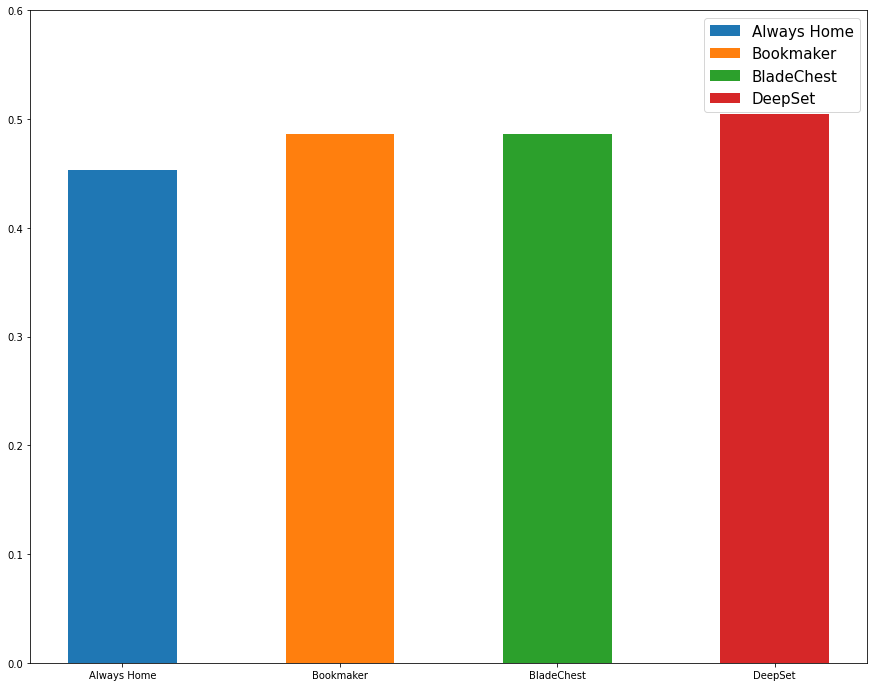

In [ ]:
acc_dict = {'Always Home' : 0.4537,
'Bookmaker' : 0.4860504388809204,
'BladeChest' : 0.4860504388809204,
'DeepSet' : 0.5045}

x = np.arange(4)

fig, ax = plt.subplots()
for i in range(4):
  ax.bar(
      i,
      list(acc_dict.values())[i],
      width=0.5,
      label=list(acc_dict.keys())[i]
  )

ax.set_ylim((0, 0.6))
ax.set_xticks(x)
ax.set_xticklabels(list(acc_dict.keys()))

ax.legend(prop={'size': 15})
fig.set_size_inches((15, 12))


## RPS

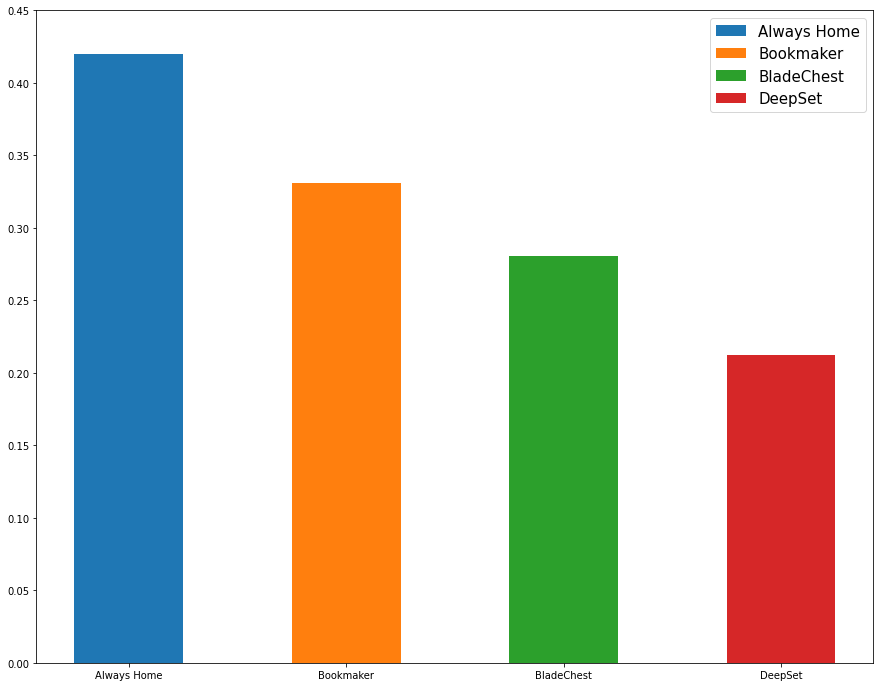

In [ ]:
acc_dict = {'Always Home' : 0.42025181813684265,
'Bookmaker' : 0.33102888339840303,
'BladeChest' : 0.28032589512584598,
'DeepSet' : 0.2122002467206415}

x = np.arange(4)

fig, ax = plt.subplots()
for i in range(4):
  ax.bar(
      i,
      list(acc_dict.values())[i],
      width=0.5,
      label=list(acc_dict.keys())[i]
  )

ax.set_ylim((0, 0.45))
ax.set_xticks(x)
ax.set_xticklabels(list(acc_dict.keys()))

ax.legend(prop={'size': 15})
fig.set_size_inches((15, 12))
